# Making some quick calculations to get $F_{ij}$ working for $C_l^{TT},C_l^{TE},C_l^{EE}$ observables

In [27]:
import crosspower as cp
#import FisherCl as fcl
#import FisherCl2 as fcl
#from numpy.linalg import eigh
import camb

# set plotting to be in the notebook instead of its own qt window
%matplotlib inline

In [28]:
# set cosmological parameters

cosParams = {
        'H0'    : None, #67.51, #setting H0=None allows cosmomc_theta to be used instead
        'cosmomc_theta'           : 1.04087e-2,
        'ombh2' : 0.02226,
        'omch2' : 0.1193,
        'omk'   : 0,
        'tau'   : 0.063,

        'As'    : 2.130e-9,
        'ns'    : 0.9653,
        'r'     : 0,
        'kPivot': 0.05,

        # if fiducial mnu is changed, need to adjust omch2 as well
        'mnu'   : 0.06, # (eV)
        #'mnu'   : 0.058, # Lloyd suggested this value for fiducial; adjust omch2 if I do use it
        'nnu'   : 3.046,
        'standard_neutrino_neff'  : 3.046,
        'num_massive_neutrinos'   : 1,
        'neutrino_hierarchy'      : 'normal'}


In [106]:
# set cosmological parameters
# step sizes from Kevin's SPT-3G forecasting notebook
"""params_base_theta={'H0':None,'cosmomc_theta':fish_param(1.04076967/100,0.000323773),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873,0.0115),
                           'ns':fish_param( 0.9681,0.0044),
                           'lmax':6000,'lens_potential_accuracy':5.0}"""
#                   ('lcdm_mnu',{'mnu':fish_param(.06,0.01)}),
"""
cosParams = {
        'H0'    : None, #67.51, #setting H0=None allows cosmomc_theta to be used instead
        'cosmomc_theta'           : 1.04076967e-2,
        'ombh2' : 0.02227,
        'omch2' : 0.1413-0.02227,
        'omk'   : 0,
        'tau'   : 0.067,

        'As'    : 1.873e-9,
        'ns'    : 0.9681,
        'r'     : 0,
        'kPivot': 0.05,

        # if fiducial mnu is changed, need to adjust omch2 as well
        'mnu'   : 0.06, # (eV)
        #'mnu'   : 0.058, # Lloyd suggested this value for fiducial; adjust omch2 if I do use it
        'nnu'   : 3.046,
        'standard_neutrino_neff'  : 3.046,
        'num_massive_neutrinos'   : 1,
        'neutrino_hierarchy'      : 'normal'}
"""

"\ncosParams = {\n        'H0'    : None, #67.51, #setting H0=None allows cosmomc_theta to be used instead\n        'cosmomc_theta'           : 1.04076967e-2,\n        'ombh2' : 0.02227,\n        'omch2' : 0.1413-0.02227,\n        'omk'   : 0,\n        'tau'   : 0.067,\n\n        'As'    : 1.873e-9,\n        'ns'    : 0.9681,\n        'r'     : 0,\n        'kPivot': 0.05,\n\n        # if fiducial mnu is changed, need to adjust omch2 as well\n        'mnu'   : 0.06, # (eV)\n        #'mnu'   : 0.058, # Lloyd suggested this value for fiducial; adjust omch2 if I do use it\n        'nnu'   : 3.046,\n        'standard_neutrino_neff'  : 3.046,\n        'num_massive_neutrinos'   : 1,\n        'neutrino_hierarchy'      : 'normal'}\n"

In [29]:
# get a matterPower object
#reload(cp)
myPk = cp.matterPower(**cosParams)

zs.size:  998


In [30]:
# copy some setup from FisherCl2.py

#myParams = myPk.cosParams
myParams = cosParams
nz = 1000

# parameters list:
nCosParams = 7 # 6 LCDM + Mnu
paramList = ['ombh2','omch2','cosmomc_theta','As','ns','tau','mnu']
# step sizes for discrete derivatives: must correspond to paramList entries!
#   from Allison et. al. (2015) Table III.
deltaP = [0.0008,0.0030,0.0050e-2,0.1e-9,0.010,0.020,0.020] #last one in eV

# step sizes from Kevin's SPT-3G forecasting notebook
"""params_base_theta={'H0':None,'cosmomc_theta':fish_param(1.04076967/100,0.000323773),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873,0.0115),
                           'ns':fish_param( 0.9681,0.0044),
                           'lmax':6000,'lens_potential_accuracy':5.0}"""
#                   ('lcdm_mnu',{'mnu':fish_param(.06,0.01)}),
#deltaP = [0.0002,0.0011,0.000323773,0.0115e-9,0.0044,0.013,0.01]

# cut deltaP in half to see effect
#deltaP = np.array(deltaP)/2.
#deltaP = np.array(deltaP)/10.

# double deltaP to see effect
#deltaP = np.array(deltaP)*2.
#deltaP = np.array(deltaP)*10.


# make this a function that uses some global variables
def getDerivParams(deltaP):
    """
        deltaP: array of parameter step sizes
        Returns:
            parsUpper: array of camb pars objects, one element for each parameter
            parsLower: array of camb pars objects, one element for each parameter
    """
    
    # get more matterPower objects for numeric differentiation
    print 'creating parameter sets...'
    myParamsUpper = []
    myParamsLower = []
    parsUpper = []
    parsLower = []
    for cParamNum in range(nCosParams):
        #print 'creating matter power spectra for ',paramList[cParamNum],' derivative...'
        print 'creating parameter set for ',paramList[cParamNum],' derivative...'
        # add parameter dictionary to lists; HAVE TO BE COPIES!!!
        myParamsUpper.append(myParams.copy())
        myParamsLower.append(myParams.copy())
        # modify parameter number cParamNum in dictionaries
        myParamsUpper[cParamNum][paramList[cParamNum]] += deltaP[cParamNum]
        myParamsLower[cParamNum][paramList[cParamNum]] -= deltaP[cParamNum]


        # toggle this section off for comparison with Kevin's Fisher result:
        """
        # check for mnu modification and adjust omch2 if necessary
        if paramList[cParamNum] == 'mnu':
            omch2Index = np.where(np.array(paramList) == 'omch2')[0][0]
            deltaOmnh2 = deltaP[cParamNum]/94 #eq.n 12 from Wu et. al.
            #deltaOmnh2 = pars.omegan*(pars.H0/100)**2 # probably a better measure of omega_nu
            # note the -=,+= signs get reversed in next 2 lines compared to above
            myParamsUpper[cParamNum][paramList[omch2Index]] -= deltaOmnh2
            myParamsLower[cParamNum][paramList[omch2Index]] += deltaOmnh2
        """

        #print 'cPramNum: ',cParamNum,', param name: ',paramList[cParamNum]
        #print 'myParamsUpper[cParamNum][paramList[cParamNum]]: ',myParamsUpper[cParamNum][paramList[cParamNum]]
        #print 'myParamsLower[cParamNum][paramList[cParamNum]]: ',myParamsLower[cParamNum][paramList[cParamNum]]
        #print 'deltaP[cParamNum]: ',deltaP[cParamNum]

        # create matter power objects and add to lists
        # really I just need matterPower.pars, but this is a fast way to code it
        #myPksUpper.append(cp.matterPower(nz=nz,**myParamsUpper[cParamNum]))
        #myPksLower.append(cp.matterPower(nz=nz,**myParamsLower[cParamNum]))

        # switch to using just pars objects.  No longer "myPks", should be renamed
        parsUpper.append(cp.matterPower.getPars(myPk,**myParamsUpper[cParamNum]))
        parsLower.append(cp.matterPower.getPars(myPk,**myParamsLower[cParamNum]))
        
    #return myPksUpper,myPksLower
    return parsUpper,parsLower
    


In [109]:
def checkPars(pars):
    H0 = pars.H0
    print 'ombh2: ',pars.omegab*(H0/100)**2
    print 'omch2: ',pars.omegac*(H0/100)**2
    print 'H_0: ',H0, '(proxy for theta?)'
    #print 'initial condition vector: ',pars.InitialConditionVector
    print 'As: ',pars.InitPower.ScalarPowerAmp[0]
    print 'ns: ',pars.InitPower.an[0]
    print 'tau: ',pars.Reion.optical_depth
    #print 'omega_n: ',pars.omegan
    print 'omega_n*94*h**2: ',pars.omegan*94*(H0/100)**2
    
    #print '\n'
    #print pars
    

In [110]:
# set to True to check parameter values
if False:
    for cParamNum in range(nCosParams):
        print '\nContents of pars objects for parameter set ',cParamNum+1,' for parameter ',paramList[cParamNum], \
              ' with delta ',deltaP[cParamNum]
        checkPars(myPksUpper[cParamNum])
        checkPars(myPksLower[cParamNum])

In [111]:
# get all cross power spectra
nMaps = 2 # T,E
lmax = 2000 # may want to match lmax in other Fisher calculation

# rewrite as function that uses global variables
def getPowerSpectra(parsUpper,parsLower):
    #def getPowerSpectra(myPksUpper,myPksLower):
    #lmax = 2000 # may want to match lmax in other Fisher calculation
    pars = myPk.pars
    #pars.set_for_lmax(lmax, lens_potential_accuracy=0)
    # try kicking it up for comaprison against Kevin's result
    lensLmax = lmax #3*lmax
    lpa = 0 #5.0
    #aBoost = 1
    #aBoost = 2
    #aBoost = 3
    #aBoost = 4
    aBoost = 5
    pars.set_for_lmax(lensLmax, lens_potential_accuracy=lpa)
    pars.set_accuracy(AccuracyBoost=aBoost)

    #calculate results for these parameters
    print 'getting Cl power spectrum'
    results = camb.get_results(pars)

    #get dictionary of CAMB power spectra
    powers =results.get_cmb_power_spectra(pars)
    #for name in powers: print name

    #get the total lensed CMB power spectra versus unlensed
    #myClName = 'total'
    myClName = 'unlensed_scalar'
    myCl = powers[myClName]

    #totCl=powers['total']
    #unlensedCl=powers['unlensed_scalar']
    print myCl.shape
    #Python Cl arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
    #The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).

    # re-arrange the data structure to be consistent with code in FisherMatrix
    #nMaps = 2 # T,E
    crossCls      = np.zeros((nMaps,nMaps,           lmax))
    crossClsPlus  = np.zeros((nMaps,nMaps,nCosParams,lmax))
    crossClsMinus = np.zeros((nMaps,nMaps,nCosParams,lmax))

    crossCls[0,0] = myCl[:lmax,0] # TT
    crossCls[0,1] = myCl[:lmax,3] # TE
    crossCls[1,0] = myCl[:lmax,3] # ET
    crossCls[1,1] = myCl[:lmax,1] # EE

    # get the perturbed versions
    for paramNum in range(nCosParams):
        print 'getting Cl power spectra for parameter ',paramList[paramNum]
        myParsUpper = parsUpper[paramNum] #.pars
        myParsLower = parsLower[paramNum] #.pars
        myParsUpper.set_for_lmax(lensLmax, lens_potential_accuracy=lpa)
        myParsLower.set_for_lmax(lensLmax, lens_potential_accuracy=lpa)
        myParsUpper.set_accuracy(AccuracyBoost=aBoost)
        myParsLower.set_accuracy(AccuracyBoost=aBoost)


        #calculate results for these parameters
        resultsUpper = camb.get_results(myParsUpper)
        resultsLower = camb.get_results(myParsLower)

        #get dictionary of CAMB power spectra
        powersUpper =resultsUpper.get_cmb_power_spectra(myParsUpper)
        powersLower =resultsLower.get_cmb_power_spectra(myParsLower)

        #get the selected power spectra
        myClUpper=powersUpper[myClName]
        myClLower=powersLower[myClName]

        #store them
        crossClsPlus[0,0,paramNum]  = myClUpper[:lmax,0] # TT
        crossClsPlus[0,1,paramNum]  = myClUpper[:lmax,3] # TE
        crossClsPlus[1,0,paramNum]  = myClUpper[:lmax,3] # ET
        crossClsPlus[1,1,paramNum]  = myClUpper[:lmax,1] # EE

        crossClsMinus[0,0,paramNum] = myClLower[:lmax,0] # TT
        crossClsMinus[0,1,paramNum] = myClLower[:lmax,3] # TE
        crossClsMinus[1,0,paramNum] = myClLower[:lmax,3] # ET
        crossClsMinus[1,1,paramNum] = myClLower[:lmax,1] # EE

    return crossCls,crossClsPlus,crossClsMinus


In [112]:
# get derivatives wrt parameters

# rewrite as function that uses global variables
def getDClVecs(crossCls,crossClsPlus,crossClsMinus):
    
    nCls = nMaps*(nMaps+1)/2 # This way removes redundancies, eg C_l^kg = C_l^gk
    print 'starting creation of C_l derivatives... '
    #dClVecs = np.empty((nCls, nCosParams, lmax+51))
    #Clzeros = np.zeros(lmax+51) # for putting into dClVecs when needed
    dClVecs = np.empty((nCls, nCosParams, lmax))

    for map1 in range(nMaps):
        print 'starting derivative set ',map1+1,' of ',nMaps,'... '
        for map2 in range(map1,nMaps):
            mapIdx  = map1*nMaps+map2 -map1*(map1+1)/2  
                                       # mapIdx = map index
            for pIdx in range(nCosParams):
                dClPlus  = crossClsPlus[map1,map2,pIdx]
                dClMinus = crossClsMinus[map1,map2,pIdx]
                dClVecs[mapIdx, pIdx] = (dClPlus-dClMinus)/(2*deltaP[pIdx])

    return dClVecs


In [113]:
# verify mapIdx does what it's supposed to: count
for map1 in range(nMaps):
    for map2 in range(map1,nMaps):
        mapIdx  = map1*nMaps+map2 -map1*(map1+1)/2  
        print map1, map2, mapIdx

0 0 0
0 1 1
1 1 2


deltaP:  [0.0008, 0.003, 5e-05, 1e-10, 0.01, 0.02, 0.02]
starting set  1  with Delta parameters  [  8.00000000e-05   3.00000000e-04   5.00000000e-06   1.00000000e-11
   1.00000000e-03   2.00000000e-03   2.00000000e-03]
creating parameter sets...
creating parameter set for  ombh2  derivative...
creating parameter set for  omch2  derivative...
creating parameter set for  cosmomc_theta  derivative...
creating parameter set for  As  derivative...
creating parameter set for  ns  derivative...
creating parameter set for  tau  derivative...
creating parameter set for  mnu  derivative...


ombh2:  0.02234
omch2:  0.1193
H_0:  67.558393069 (proxy for theta?)
As:  2.13e-09
ns:  0.9653
tau:  0.063
omega_n*94*h**2:  0.0606435258047
ombh2:  0.02218
omch2:  0.1193
H_0:  67.426663272 (proxy for theta?)
As:  2.13e-09
ns:  0.9653
tau:  0.063
omega_n*94*h**2:  0.0606435258047
getting Cl power spectrum
(2051, 4)
getting Cl power spectra for parameter  ombh2
getting Cl power spectra for parameter  omch2
g

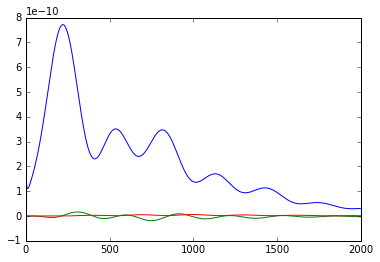

starting creation of C_l derivatives... 
starting derivative set  1  of  2 ... 
starting derivative set  2  of  2 ... 
starting set  2  with Delta parameters  [  4.00000000e-04   1.50000000e-03   2.50000000e-05   5.00000000e-11
   5.00000000e-03   1.00000000e-02   1.00000000e-02]
creating parameter sets...
creating parameter set for  ombh2  derivative...
creating parameter set for  omch2  derivative...
creating parameter set for  cosmomc_theta  derivative...
creating parameter set for  As  derivative...
creating parameter set for  ns  derivative...
creating parameter set for  tau  derivative...
creating parameter set for  mnu  derivative...


ombh2:  0.02266
omch2:  0.1193
H_0:  67.8231350549 (proxy for theta?)
As:  2.13e-09
ns:  0.9653
tau:  0.063
omega_n*94*h**2:  0.0606435258047
ombh2:  0.02186
omch2:  0.1193
H_0:  67.1645320834 (proxy for theta?)
As:  2.13e-09
ns:  0.9653
tau:  0.063
omega_n*94*h**2:  0.0606435258047
getting Cl power spectrum
(2051, 4)
getting Cl power spectra for 

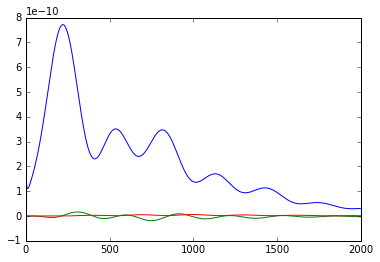

starting creation of C_l derivatives... 
starting derivative set  1  of  2 ... 
starting derivative set  2  of  2 ... 
starting set  3  with Delta parameters  [  8.00000000e-04   3.00000000e-03   5.00000000e-05   1.00000000e-10
   1.00000000e-02   2.00000000e-02   2.00000000e-02]
creating parameter sets...
creating parameter set for  ombh2  derivative...
creating parameter set for  omch2  derivative...
creating parameter set for  cosmomc_theta  derivative...
creating parameter set for  As  derivative...
creating parameter set for  ns  derivative...
creating parameter set for  tau  derivative...
creating parameter set for  mnu  derivative...


ombh2:  0.02306
omch2:  0.1193
H_0:  68.1563771999 (proxy for theta?)
As:  2.13e-09
ns:  0.9653
tau:  0.063
omega_n*94*h**2:  0.0606435258047
ombh2:  0.02146
omch2:  0.1193
H_0:  66.8394586651 (proxy for theta?)
As:  2.13e-09
ns:  0.9653
tau:  0.063
omega_n*94*h**2:  0.0606435258047
getting Cl power spectrum
(2051, 4)
getting Cl power spectra for 

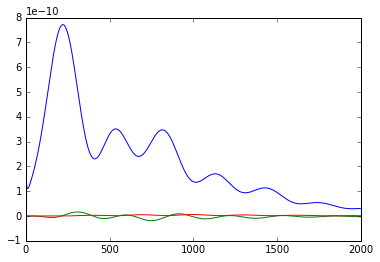

starting creation of C_l derivatives... 
starting derivative set  1  of  2 ... 
starting derivative set  2  of  2 ... 
starting set  4  with Delta parameters  [  1.60000000e-03   6.00000000e-03   1.00000000e-04   2.00000000e-10
   2.00000000e-02   4.00000000e-02   4.00000000e-02]
creating parameter sets...
creating parameter set for  ombh2  derivative...
creating parameter set for  omch2  derivative...
creating parameter set for  cosmomc_theta  derivative...
creating parameter set for  As  derivative...
creating parameter set for  ns  derivative...
creating parameter set for  tau  derivative...
creating parameter set for  mnu  derivative...


ombh2:  0.02386
omch2:  0.1193
H_0:  68.8300933202 (proxy for theta?)
As:  2.13e-09
ns:  0.9653
tau:  0.063
omega_n*94*h**2:  0.0606435258047
ombh2:  0.02066
omch2:  0.1193
H_0:  66.198566126 (proxy for theta?)
As:  2.13e-09
ns:  0.9653
tau:  0.063
omega_n*94*h**2:  0.0606435258047
getting Cl power spectrum
(2051, 4)
getting Cl power spectra for p

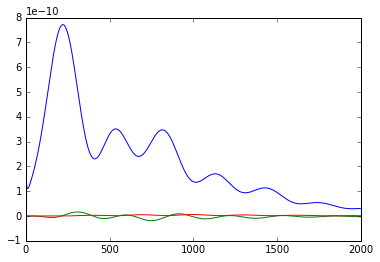

starting creation of C_l derivatives... 
starting derivative set  1  of  2 ... 
starting derivative set  2  of  2 ... 
starting set  5  with Delta parameters  [  8.00000000e-03   3.00000000e-02   5.00000000e-04   1.00000000e-09
   1.00000000e-01   2.00000000e-01   2.00000000e-01]
creating parameter sets...
creating parameter set for  ombh2  derivative...
creating parameter set for  omch2  derivative...
creating parameter set for  cosmomc_theta  derivative...
creating parameter set for  As  derivative...
creating parameter set for  ns  derivative...
creating parameter set for  tau  derivative...
creating parameter set for  mnu  derivative...


ombh2:  0.03026
omch2:  0.1193
H_0:  74.4803797871 (proxy for theta?)
As:  2.13e-09
ns:  0.9653
tau:  0.063
omega_n*94*h**2:  0.0606435258047
ombh2:  0.01426
omch2:  0.1193
H_0:  61.7408055179 (proxy for theta?)
As:  2.13e-09
ns:  0.9653
tau:  0.063
omega_n*94*h**2:  0.0606435258047
getting Cl power spectrum
(2051, 4)
getting Cl power spectra for 

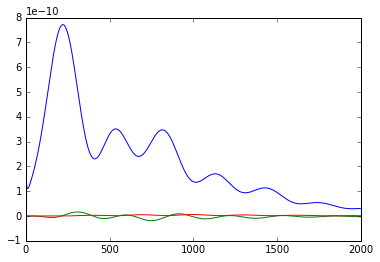

starting creation of C_l derivatives... 
starting derivative set  1  of  2 ... 
starting derivative set  2  of  2 ... 


In [114]:
# loop it
print 'deltaP: ',deltaP
dp = np.array(deltaP)
deltaP_half = dp/2.
deltaP_tenth = dp/10.
deltaP_double = dp*2.
deltaP_decade = dp*10.
deltaP_list = [deltaP_tenth,deltaP_half,dp,deltaP_double,deltaP_decade]

dClVecs_list = []
for pSetNum,deltaP in enumerate(deltaP_list):
    print 'starting set ',pSetNum+1,' with Delta parameters ',deltaP
    parsUpper,parsLower = getDerivParams(deltaP)
    
    # just check parameter 0
    print '\n'
    checkPars(parsUpper[0]) #.pars)
    checkPars(parsLower[0]) #.pars)
    
    crossCls,crossClsPlus,crossClsMinus = getPowerSpectra(parsUpper,parsLower)
    
    plt.plot(crossCls[0,0])
    plt.plot(crossCls[0,1])
    plt.plot(crossCls[1,1])
    plt.show()
    
    dClVecs = getDClVecs(crossCls,crossClsPlus,crossClsMinus)
    dClVecs_list.append(dClVecs)
    

In [115]:
# save it.
import pickle
#filehandler = open('dClVecsList1.obj','w')
#filehandler = open('dClVecsList3.obj','w')
#filehandler = open('dClVecsList5.obj','w')
pickle.dump(dClVecs_list,filehandler)

In [20]:
# load it
import pickle
file = open('dClVecsList5.obj','r')
dClVecs_list = pickle.load(file)

deltaP = [0.0008,0.0030,0.0050e-2,0.1e-9,0.010,0.020,0.020] #last one in eV
dp = np.array(deltaP)
deltaP_half = dp/2.
deltaP_tenth = dp/10.
deltaP_double = dp*2.
deltaP_decade = dp*10.
deltaP_list = [deltaP_tenth,deltaP_half,dp,deltaP_double,deltaP_decade]

nCosParams = 7 # 6 LCDM + Mnu
paramList = ['ombh2','omch2','cosmomc_theta','As','ns','tau','mnu']
nMaps=2
nCls = 3
lmax=2000

In [31]:
#def getPowerSpectra(myPksUpper,myPksLower):
#lmax = 2000 # may want to match lmax in other Fisher calculation
pars = myPk.pars
#pars.set_for_lmax(lmax, lens_potential_accuracy=0)
# try kicking it up for comaprison against Kevin's result
lensLmax = lmax #3*lmax
lpa = 0 #5.0
#aBoost = 1
#aBoost = 2
#aBoost = 3
#aBoost = 4
aBoost = 5
pars.set_for_lmax(lensLmax, lens_potential_accuracy=lpa)
pars.set_accuracy(AccuracyBoost=aBoost)

#calculate results for these parameters
print 'getting Cl power spectrum'
results = camb.get_results(pars)

#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars)
#for name in powers: print name

#get the total lensed CMB power spectra versus unlensed
#myClName = 'total'
myClName = 'unlensed_scalar'
myCl = powers[myClName]

#totCl=powers['total']
#unlensedCl=powers['unlensed_scalar']
print myCl.shape
#Python Cl arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).

# re-arrange the data structure to be consistent with code in FisherMatrix
#nMaps = 2 # T,E
crossCls      = np.zeros((nMaps,nMaps,           lmax))
crossClsPlus  = np.zeros((nMaps,nMaps,nCosParams,lmax))
crossClsMinus = np.zeros((nMaps,nMaps,nCosParams,lmax))

crossCls[0,0] = myCl[:lmax,0] # TT
crossCls[0,1] = myCl[:lmax,3] # TE
crossCls[1,0] = myCl[:lmax,3] # ET
crossCls[1,1] = myCl[:lmax,1] # EE


getting Cl power spectrum
(2051, 4)


In [21]:
print 'nCls, nCosParams, lmax'
dClVecs_list[0].shape

nCls, nCosParams, lmax


(3, 7, 2000)

In [22]:
print paramList

['ombh2', 'omch2', 'cosmomc_theta', 'As', 'ns', 'tau', 'mnu']


In [23]:
# pull mnu part out
parIndex = 6
mnu_tenth  = dClVecs_list[0][:,parIndex,:]
mnu_half   = dClVecs_list[1][:,parIndex,:]
mnu_nom    = dClVecs_list[2][:,parIndex,:]
mnu_double = dClVecs_list[3][:,parIndex,:]
mnu_decade = dClVecs_list[4][:,parIndex,:]

# make ratios
tenthToOne = mnu_tenth/mnu_nom
halfToOne = mnu_half/mnu_nom
doubleToOne = mnu_double/mnu_nom
decadeToOne = mnu_decade/mnu_nom


/sw/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide
/sw/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide
/sw/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in divide
/sw/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide


<IPython.core.display.Javascript object>


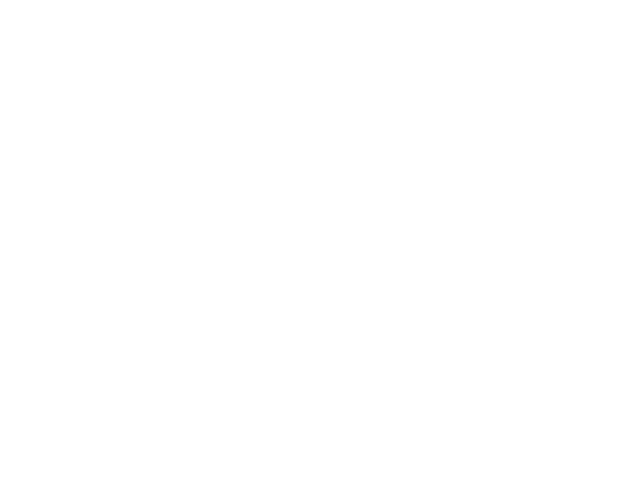

In [24]:
# select observable
#obsNum = 0 # TT
#obsNum = 1 # TE
obsNum = 2 # EE

%matplotlib notebook
plt.plot(mnu_tenth[obsNum],label='one tenth')
plt.plot(mnu_half[obsNum],label='one half')
plt.plot(mnu_nom[obsNum],label='nominal')
plt.plot(mnu_double[obsNum],label='double')
plt.plot(mnu_decade[obsNum],label='decuple')
#plt.legend(loc='upper right') #TT, TE
plt.legend(loc='lower left') #EE
plt.title('dCl^EE / dmnu at CAMB accuracyBoost=5')
#plt.ylim((-1.5e-10,1.5e-10)) #TT
#plt.ylim((-0.2e-11,0.2e-11)) #TT
#plt.ylim((-1.5e-11,1.5e-11)) #TE
#plt.ylim((-0.8e-11,0.8e-11)) #TE
#plt.ylim((-1e-12,0.2e-12)) #EE
#plt.ylim((-0.1e-12,0.05e-12)) #EE
plt.show()


# I don't need the rest of this for checking dClVecs

In [25]:
# more code from FisherMatrix.__init__
# create covariance matrix
print 'building covariance matrix... '

nCls = nMaps*(nMaps+1)/2 # This way removes redundancies, eg C_l^kg = C_l^gk
#covar = np.zeros((nCls,nCls,lmax+51))
#ells = np.arange(lmax+51)
covar = np.zeros((nCls,nCls,lmax))
ells = np.arange(lmax)

# create obsList to contain base nMaps representation of data label
obsList = np.zeros(nCls)

for map1 in range(nMaps):
    print 'starting covariance set ',map1+1,' of ',nMaps,'... '
    for map2 in range(map1, nMaps):
        covIndex1 = map1*nMaps+map2-map1*(map1+1)/2     # shortens the array
        obsList[covIndex1] = map1*nMaps+map2       # base nMaps representation
        for map3 in range(nMaps):
          for map4 in range(map3, nMaps):
            covIndex2 = map3*nMaps+map4-map3*(map3+1)/2 # shortens the array
            if covIndex1 <= covIndex2:
              covar[covIndex1,covIndex2] = (crossCls[map1,map3]*crossCls[map2,map4] + \
                                            crossCls[map1,map4]*crossCls[map2,map3] )/(2.*ells+1)
            else:                                       # avoid double calculation
              covar[covIndex1,covIndex2] = covar[covIndex2,covIndex1]

# invert covariance matrix
print 'inverting covariance matrix... '
# transpose of inverse of transpose is inverse of original
# need to do this to get indices in order that linalg.inv wants them
invCov = np.transpose(np.linalg.inv(np.transpose(covar[:,:,2:])))
ells = ells[2:]
print 'lmin = ',ells[0]
print 'obsList: ',obsList

building covariance matrix... 
starting covariance set  1  of  2 ... 


NameError: name 'crossCls' is not defined

# select a dClVecs and deltaP for use on the rest of the notebook


In [ ]:
# nominal:
#deltaP = np.array([0.0008,0.0030,0.0050e-2,0.1e-9,0.010,0.020,0.020]) #last one in eV
deltaNum = 0
deltaP = deltaP_list[deltaNum]
dClVecs = dClVecs_list[deltaNum]

In [ ]:
#Build Fisher matrix
lmin = 50 #to match Allison et. al. and justify no ISW effect
#multply vectorT,invcov,vector and add up
print 'building Fisher matrix from components...'
print 'invCov.shape: ',invCov.shape,', dClVecs.shape: ',dClVecs.shape
Fij = np.zeros((nCosParams,nCosParams)) # indices match those in paramList
for i in range(nCosParams):
    print 'starting bin set ',i+1,' of ',nCosParams
    dClVec_i = dClVecs[:,i,:] # shape (nCls,nElls)
    for j in range(nCosParams):
        dClVec_j = dClVecs[:,j,:] # shape (nCls,nElls)
        # ugh.  don't like nested loops in Python... but easier to program...
        for ell in range(lmin-2,lmax-2):
          myCov = invCov[:,:,ell]  #note invCov has no ell=0,1 but dClVecs do
          fij = np.dot(dClVec_i[:,ell+2],np.dot(myCov,dClVec_j[:,ell+2]))
          Fij[i,j] += fij
    
print 'creation of Fisher Matrix complete!\n'

# Have a look at it
print 'Fij:'
print Fij
# check eigenvalues
w,v = np.linalg.eigh(np.linalg.inv(Fij))
print 'eigenvalues of F_ij^-1:'
print w

In [ ]:
# add prior on Tau for comparison with Kevin's result
tauNum = 5
tauPrior = 1/0.02**2
print Fij[tauNum,tauNum]
Fij[tauNum,tauNum] = Fij[tauNum,tauNum] + tauPrior 
print Fij[tauNum,tauNum]

# Check out these uncertainties!

In [ ]:
sigmas = np.sqrt(np.diag(np.linalg.inv(Fij)))
for i,p in enumerate(paramList):
    print p, sigmas[i]

In [ ]:
# get lensing and galaxy Fisher matrix to add
import FisherCl2 as fcl
import pickle
filehandler2 = open('Fisher_4_4.obj', 'r') 
Fobj = pickle.load(filehandler2) 

print Fobj.obsList
print Fobj.paramList

In [ ]:
# remake the kappa-g Fij with lmin=50 to match the other Fij
# make comparison against version with higher lmin
# copy some code from FisherMatrix.__init__

def makeFisher(Fobj,lmin):
    """ code copied from FisherMatrix.__init__
        Inputs:
            Fobj:
            lmin: minimum ell to make Fij
    """
    #Build Fisher matrix
    #multply vectorT,invcov,vector and add up
    print 'building Fisher matrix from components...'
    print 'invCov.shape: ',Fobj.invCov.shape,', dClVecs.shape: ',Fobj.dClVecs.shape
    nParams = Fobj.nParams
    lmax = 2000 #Fobj.lmax
    Fij = np.zeros((nParams,nParams)) # indices match those in paramList
    for i in range(nParams):
      print 'starting bin set ',i+1,' of ',nParams
      dClVec_i = Fobj.dClVecs[:,i,:] # shape (nCls,nElls)
      for j in range(nParams):
        dClVec_j = Fobj.dClVecs[:,j,:] # shape (nCls,nElls)
        # ugh.  don't like nested loops in Python... but easier to program...
        for ell in range(lmin-2,lmax-1): #-2 to match the indices
          myCov = Fobj.invCov[:,:,ell]
          fij = np.dot(dClVec_i[:,ell],np.dot(myCov,dClVec_j[:,ell]))
          
          Fij[i,j] += fij
    
    print 'creation of Fisher Matrix complete!\n'
    return Fij

In [ ]:
Fij2 = makeFisher(Fobj,50)
sigmas2 = np.sqrt(np.diag(np.linalg.inv(Fij2)))

In [ ]:
print 'comparison of T,E sigmas with kappa,g sigmas:'
#sigmas2 = Fobj.getSigmas()
for i,p in enumerate(paramList):
    print p, sigmas[i],sigmas2[i]

# Combine the Fisher matrices and see smaller sigmas

In [ ]:
print 'comparison of sigma(T,E), sigma(kappa,g), and sigma(T,E,kappa,g):\n'
#FijSum = Fij+Fobj.Fij[:nCosParams,:nCosParams]  #oops, that was the lmin=2 version
FijSum = Fij+Fij2[:nCosParams,:nCosParams]   # this one has lmin=50
#print FijSum
#print FijSum-Fij
#print FijSum-Fij2[:nCosParams,:nCosParams]
sigmas3 = np.sqrt(np.diag(np.linalg.inv(FijSum)))
#for i,p in enumerate(paramList):
#    print p, sigmas[i],sigmas2[i],sigmas3[i]
    
from prettytable import PrettyTable
t = PrettyTable(['Parameter', 'sigma(T,E)','sigma(k,g)','sigma(T,E,k,g)'])
for i,p in enumerate(paramList):
    t.add_row([p,"%5.3g" % sigmas[i],"%5.3g" % sigmas2[i],"%5.3g" % sigmas3[i]])
print t

In [ ]:
# the previous result fixed the biases for the combined sigmas.
# do a different version without fixing them
print 'comparison of sigma(T,E), sigma(kappa,g), and sigma(T,E,kappa,g):\n'
FijSum2 = Fij2.copy()
#print FijSum2
FijSum2[:nCosParams,:nCosParams] = FijSum2[:nCosParams,:nCosParams] + Fij
#print Fij2
#print FijSum2
#print FijSum2-Fij2

sigmas4 = np.append(sigmas,[0,0,0,0])
#FijSum = Fij+Fobj.Fij[:nCosParams,:nCosParams]
sigmas5 = np.sqrt(np.diag(np.linalg.inv(FijSum2)))
#for i,p in enumerate(Fobj.paramList):
#    print p, sigmas4[i],sigmas2[i],sigmas5[i]
    
from prettytable import PrettyTable
t = PrettyTable(['Parameter', 'sigma(T,E)','sigma(k,g)','sigma(T,E,k,g)'])
for i,p in enumerate(Fobj.paramList):
    t.add_row([p,"%5.3g" % sigmas4[i],"%5.3g" % sigmas2[i],"%5.3g" % sigmas5[i]])
print t

To add:
    switch to halofit
    shot noise
    lensing recon noise
    DE params
    Improved bias model  (important but hard; not for 'first paper')
    Inverted nu hiearchy: Is there any sensitivity beyond Sigma mnu (transition region)
        (drawing: power stepping down for each species instead of one step down with ell)
        Ll: guesses probably not

priorities: byeonhee,kevin comparisons,
    include DE
    inverted nu hier
    halofit
    noise

In [32]:
# compare to Kevin's result  (reportedly from unlensed spectra; 
#   Lloyd wanted him to double check that due to the small size of mnu)
Ksigmas = {
    'As' : 8.36787928685e-11,
    'cosmomc_theta' : 1.44400712682e-06,
    'mnu' : 0.220088883622,
    'ns' : 0.00193696953962,
    'ombh2' : 4.50012028332e-05,
    'omch2' : 0.000630720967738,
    'tau' : 0.0196834629721
}

# Kevin has more results for me, using my fiducial parameter values and step sizes:
# Using lensed spectra:
Ksigmas2 = {
    'As' : 7.16774197011e-11,
    'cosmomc_theta' : 1.09586297761e-06,
    'mnu' : 0.146118415833,
    'ns' : 0.00177830934705,
    'ombh2' : 4.070676724e-05,
    'omch2' : 0.000576393112142,
    'tau' : 0.0171234498358
}

# Using unlensed spectra:
Ksigmas3 = {
    'As' : 8.33407946912e-11,
    'cosmomc_theta' : 1.69789979871e-06,
    'mnu' : 0.285834557983,
    'ns' : 0.00176069831712,
    'ombh2' : 4.1390440571e-05,
    'omch2' : 0.000566243441739,
    'tau' : 0.0195975583329
}

In [ ]:
from prettytable import PrettyTable
t = PrettyTable(['Parameter', 'sigma_Z(T,E)','sigma_K(T,E)','percent diff.'])
for i,p in enumerate(paramList):
    Zi = sigmas[i]
    Ki = Ksigmas[paramList[i]]
    diff = (Ki-Zi)/Zi *100
    t.add_row([p,"%5.3g" % Zi,"%5.3g" % Ki, "%5.3g" % diff ] )
print t

In [ ]:
print deltaP


In [ ]:
# check out Kevin's pickle
# oops, doesn't load in python 2.  Need to re-save as python 2 version.
#filehandler3 = open('test_cov_for_z.pkl', 'r') 
#Kdict = pickle.load(filehandler3) 